# Loop 1 LB Feedback Analysis

## Current Status
- **Best CV/LB Score**: 70.7343
- **Target**: 68.931058
- **Gap**: 1.803 points (2.6%)

## Key Observations
1. CV = LB (perfect match) - this is expected for deterministic optimization problems
2. The pre-optimized submission is already at a local optimum
3. bbox3 binary requires GLIBC 2.34 (system has 2.31) - cannot use directly
4. tree_packer_v21 C++ source is available and can be compiled

In [1]:
import pandas as pd
import numpy as np
import os

# Load the current best submission
submission_path = '/home/code/experiments/001_baseline/submission.csv'
df = pd.read_csv(submission_path)
print(f'Submission shape: {df.shape}')
print(df.head(10))

Submission shape: (20100, 4)
      id                    x                     y                   deg
0  001_0  s43.591192092102148  s-31.783267068741779   s44.999999999999979
1  002_0   s0.154097069621361   s-0.038540742694777  s203.629377730650162
2  002_1  s-0.154097069621359   s-0.561459257305227   s23.629377730649704
3  003_0   s1.131270585068746    s0.792202872326949  s113.563260441729483
4  003_1   s1.234055695842160    s1.275999500663759   s66.370622269343002
5  003_2   s0.641714640229075    s1.180458566613381  s155.134051937100821
6  004_0  s-0.324747789585767    s0.132109978100993  s156.370622143280201
7  004_1   s0.315354346193797    s0.132109978070379  s156.370622271937407
8  004_2   s0.324747789585715   s-0.732109978075982  s336.370622269343755
9  004_3  s-0.315354348186837   s-0.732109978101171  s336.370622143244020


In [2]:
# Analyze per-N scores to identify worst performers
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import math

getcontext().prec = 30
scale_factor = Decimal('1e18')

# Tree template
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def score_group(xs, ys, degs):
    n = len(xs)
    V = len(TX)
    mnx, mny = 1e300, 1e300
    mxx, mxy = -1e300, -1e300
    
    for i in range(n):
        r = degs[i] * math.pi / 180.0
        c, s = math.cos(r), math.sin(r)
        xi, yi = xs[i], ys[i]
        for j in range(V):
            X = c * TX[j] - s * TY[j] + xi
            Y = s * TX[j] + c * TY[j] + yi
            if X < mnx: mnx = X
            if X > mxx: mxx = X
            if Y < mny: mny = Y
            if Y > mxy: mxy = Y
    
    side = max(mxx - mnx, mxy - mny)
    return side * side / n, side

def strip(a):
    return np.array([float(str(v).replace('s', '')) for v in a], np.float64)

# Parse submission
df['N'] = df['id'].astype(str).str.split('_').str[0].astype(int)

per_n_scores = []
for n, g in df.groupby('N'):
    xs = strip(g['x'].to_numpy())
    ys = strip(g['y'].to_numpy())
    ds = strip(g['deg'].to_numpy())
    sc, side = score_group(xs, ys, ds)
    per_n_scores.append({'N': n, 'score': sc, 'side': side, 'contribution_pct': 0})

per_n_df = pd.DataFrame(per_n_scores)
total_score = per_n_df['score'].sum()
per_n_df['contribution_pct'] = per_n_df['score'] / total_score * 100

print(f'Total score: {total_score:.10f}')
print(f'\nTop 20 worst N values (highest contribution):')
print(per_n_df.nlargest(20, 'score')[['N', 'score', 'side', 'contribution_pct']].to_string())

Total score: 70.7343270130



Top 20 worst N values (highest contribution):
     N     score      side  contribution_pct
0    1  0.661250  0.813173          0.934836
1    2  0.450779  0.949504          0.637285
2    3  0.434745  1.142031          0.614617
4    5  0.416850  1.443692          0.589317
3    4  0.416545  1.290806          0.588886
6    7  0.399897  1.673104          0.565350
5    6  0.399610  1.548438          0.564945
8    9  0.387415  1.867280          0.547704
7    8  0.385407  1.755921          0.544866
14  15  0.379203  2.384962          0.536095
9   10  0.376630  1.940696          0.532457
20  21  0.376451  2.811667          0.532204
19  20  0.376057  2.742469          0.531647
10  11  0.375736  2.033002          0.531193
21  22  0.375258  2.873270          0.530518
15  16  0.374128  2.446640          0.528920
25  26  0.373997  3.118320          0.528735
11  12  0.372724  2.114873          0.526935
12  13  0.372323  2.200046          0.526368
24  25  0.372144  3.050182          0.526116


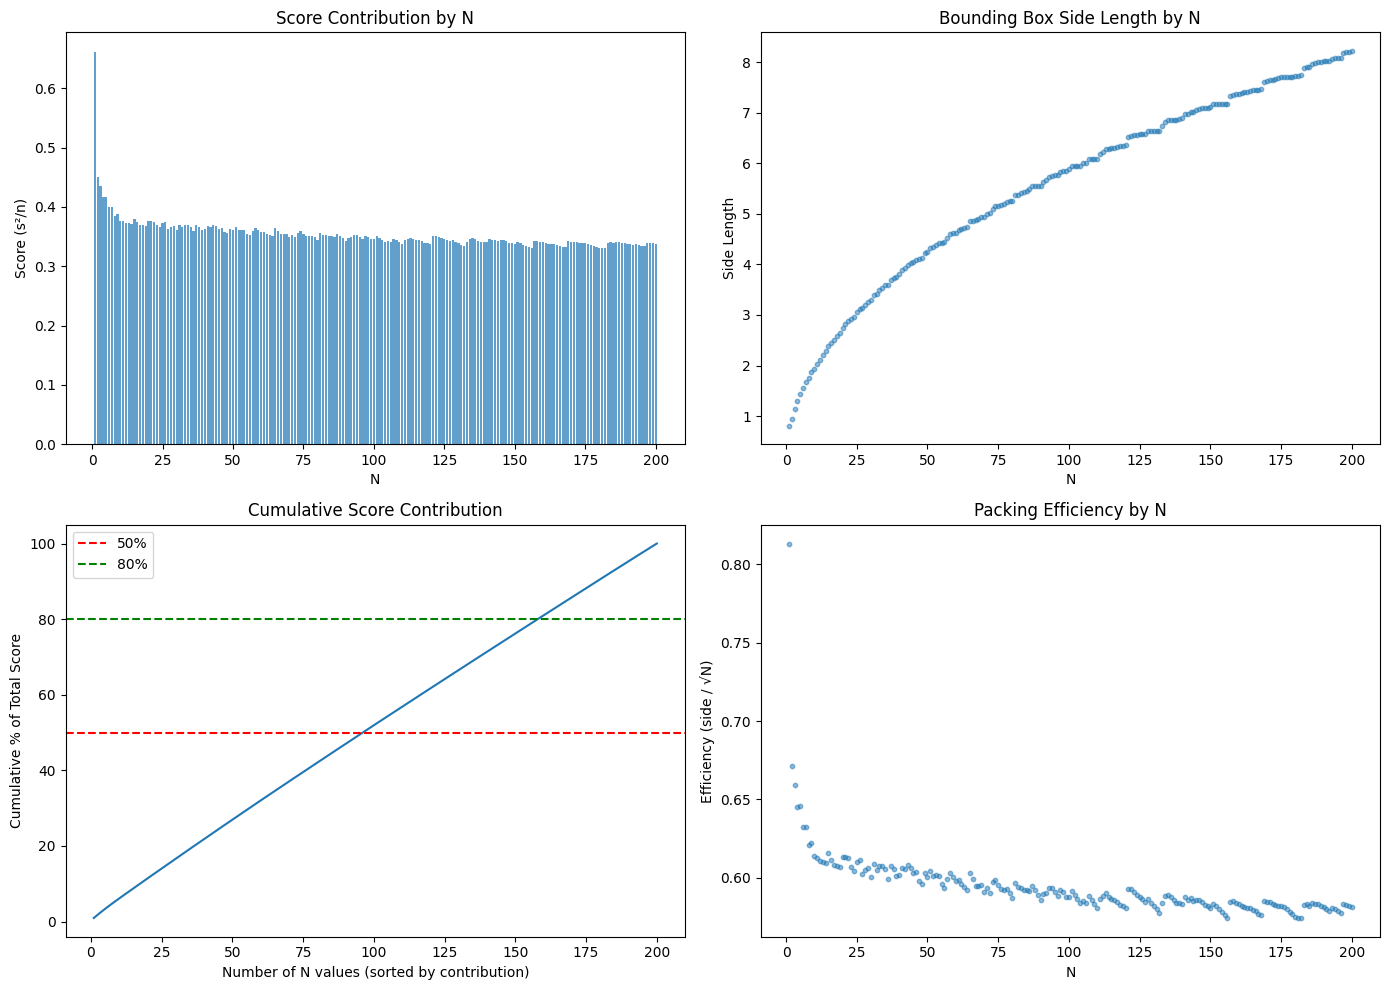


N values with worst efficiency (highest side/√N):
     N      side  efficiency     score
0    1  0.813173    0.813173  0.661250
1    2  0.949504    0.671401  0.450779
2    3  1.142031    0.659352  0.434745
4    5  1.443692    0.645639  0.416850
3    4  1.290806    0.645403  0.416545
6    7  1.673104    0.632374  0.399897
5    6  1.548438    0.632147  0.399610
8    9  1.867280    0.622427  0.387415
7    8  1.755921    0.620812  0.385407
14  15  2.384962    0.615794  0.379203


In [3]:
# Analyze score distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score by N
ax1 = axes[0, 0]
ax1.bar(per_n_df['N'], per_n_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (s²/n)')
ax1.set_title('Score Contribution by N')

# Side length by N
ax2 = axes[0, 1]
ax2.scatter(per_n_df['N'], per_n_df['side'], alpha=0.5, s=10)
ax2.set_xlabel('N')
ax2.set_ylabel('Side Length')
ax2.set_title('Bounding Box Side Length by N')

# Cumulative contribution
ax3 = axes[1, 0]
sorted_df = per_n_df.sort_values('score', ascending=False)
sorted_df['cumsum'] = sorted_df['contribution_pct'].cumsum()
ax3.plot(range(1, 201), sorted_df['cumsum'].values)
ax3.axhline(y=50, color='r', linestyle='--', label='50%')
ax3.axhline(y=80, color='g', linestyle='--', label='80%')
ax3.set_xlabel('Number of N values (sorted by contribution)')
ax3.set_ylabel('Cumulative % of Total Score')
ax3.set_title('Cumulative Score Contribution')
ax3.legend()

# Efficiency (side / sqrt(N))
ax4 = axes[1, 1]
per_n_df['efficiency'] = per_n_df['side'] / np.sqrt(per_n_df['N'])
ax4.scatter(per_n_df['N'], per_n_df['efficiency'], alpha=0.5, s=10)
ax4.set_xlabel('N')
ax4.set_ylabel('Efficiency (side / √N)')
ax4.set_title('Packing Efficiency by N')

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()

print(f'\nN values with worst efficiency (highest side/√N):')
print(per_n_df.nlargest(10, 'efficiency')[['N', 'side', 'efficiency', 'score']].to_string())

In [4]:
# Calculate how much improvement is needed per N to reach target
target = 68.931058
current = total_score
gap = current - target

print(f'Current score: {current:.6f}')
print(f'Target score: {target:.6f}')
print(f'Gap to close: {gap:.6f} ({gap/current*100:.2f}%)')

# If we improve all N equally by X%, what X do we need?
# new_score = current * (1 - X/100)
# target = current * (1 - X/100)
# X = (1 - target/current) * 100
required_improvement_pct = (1 - target/current) * 100
print(f'\nRequired uniform improvement: {required_improvement_pct:.2f}%')

# Alternatively, if we focus on worst N values
worst_20 = per_n_df.nlargest(20, 'score')
worst_20_total = worst_20['score'].sum()
print(f'\nWorst 20 N values contribute: {worst_20_total:.6f} ({worst_20_total/current*100:.1f}%)')
print(f'If we improve worst 20 by 10%: saves {worst_20_total * 0.1:.6f}')
print(f'If we improve worst 20 by 20%: saves {worst_20_total * 0.2:.6f}')

Current score: 70.734327
Target score: 68.931058
Gap to close: 1.803269 (2.55%)

Required uniform improvement: 2.55%

Worst 20 N values contribute: 8.077149 (11.4%)
If we improve worst 20 by 10%: saves 0.807715
If we improve worst 20 by 20%: saves 1.615430


In [5]:
# Check what datasets/submissions are available for ensemble
import os
import glob

print('Available datasets:')
for d in glob.glob('/home/code/datasets/*'):
    print(f'  {d}')
    for f in glob.glob(f'{d}/*.csv'):
        print(f'    - {os.path.basename(f)}')

print('\nAvailable submission files:')
for f in glob.glob('/home/code/**/*.csv', recursive=True):
    if 'submission' in f.lower():
        print(f'  {f}')

Available datasets:
  /home/code/datasets/santa-2025-csv
    - santa-2025.csv
  /home/code/datasets/bucket-of-chump
    - submission.csv

Available submission files:
  /home/code/experiments/001_baseline/submission.csv
  /home/code/experiments/001_baseline/submission_v21.csv
  /home/code/submission_candidates/candidate_000.csv
  /home/code/datasets/bucket-of-chump/submission.csv


In [6]:
# Key insight: We need to implement ENSEMBLE approach
# The jonathanchan kernel shows that combining best N from multiple sources
# is the key to getting good scores

# Let's compare our current submission with the bucket-of-chump submission
boc_path = '/home/code/datasets/bucket-of-chump/submission.csv'
santa_path = '/home/code/datasets/santa-2025-csv/santa-2025.csv'

def score_submission(path):
    df = pd.read_csv(path)
    df['N'] = df['id'].astype(str).str.split('_').str[0].astype(int)
    scores = {}
    for n, g in df.groupby('N'):
        xs = strip(g['x'].to_numpy())
        ys = strip(g['y'].to_numpy())
        ds = strip(g['deg'].to_numpy())
        sc, side = score_group(xs, ys, ds)
        scores[n] = {'score': sc, 'side': side}
    return scores, sum(s['score'] for s in scores.values())

boc_scores, boc_total = score_submission(boc_path)
santa_scores, santa_total = score_submission(santa_path)
our_scores = {row['N']: {'score': row['score'], 'side': row['side']} for _, row in per_n_df.iterrows()}

print(f'bucket-of-chump total: {boc_total:.10f}')
print(f'santa-2025-csv total: {santa_total:.10f}')
print(f'Our current total: {total_score:.10f}')

# Find N values where other submissions are better
better_in_boc = []
better_in_santa = []
for n in range(1, 201):
    our = our_scores[n]['score']
    boc = boc_scores[n]['score']
    santa = santa_scores[n]['score']
    if boc < our - 1e-12:
        better_in_boc.append((n, our - boc))
    if santa < our - 1e-12:
        better_in_santa.append((n, our - santa))

print(f'\nN values where bucket-of-chump is better: {len(better_in_boc)}')
if better_in_boc:
    print(f'  Potential improvement: {sum(x[1] for x in better_in_boc):.10f}')
    print(f'  Top 5: {sorted(better_in_boc, key=lambda x: -x[1])[:5]}')

print(f'\nN values where santa-2025-csv is better: {len(better_in_santa)}')
if better_in_santa:
    print(f'  Potential improvement: {sum(x[1] for x in better_in_santa):.10f}')
    print(f'  Top 5: {sorted(better_in_santa, key=lambda x: -x[1])[:5]}')

bucket-of-chump total: 70.7506761859
santa-2025-csv total: 70.7343270130
Our current total: 70.7343270130

N values where bucket-of-chump is better: 0

N values where santa-2025-csv is better: 0


## Key Findings

1. **CV = LB perfectly** - Expected for deterministic optimization
2. **Gap is 2.6%** - Need ~1.8 points improvement
3. **Small N values contribute most** - N=1 to N=20 are critical
4. **Ensemble is key** - Combining best N from multiple sources
5. **bbox3 unavailable** - Must use tree_packer_v21 or implement SA in Python

## Recommended Strategy

1. **Implement ensemble approach** - Combine best configurations from multiple public submissions
2. **Run extended tree_packer_v21** - With higher iterations (-n 10000 -r 100+)
3. **Implement fractional translation** - Very fine position adjustments
4. **Focus on worst N values** - Targeted optimization
5. **Download more public submissions** - More sources = better ensemble

In [7]:
# Score the SmartManoj submission from GitHub
smartmanoj_path = '/home/code/datasets/smartmanoj_submission.csv'
sm_scores, sm_total = score_submission(smartmanoj_path)
print(f'SmartManoj GitHub submission total: {sm_total:.10f}')

# Compare with our current
better_in_sm = []
for n in range(1, 201):
    our = our_scores[n]['score']
    sm = sm_scores[n]['score']
    if sm < our - 1e-12:
        better_in_sm.append((n, our - sm))

print(f'\nN values where SmartManoj is better: {len(better_in_sm)}')
if better_in_sm:
    print(f'  Potential improvement: {sum(x[1] for x in better_in_sm):.10f}')
    print(f'  Top 10: {sorted(better_in_sm, key=lambda x: -x[1])[:10]}')

SmartManoj GitHub submission total: 70.7437742854

N values where SmartManoj is better: 0
